# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_17193/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
# Class constructiong a generic loss function

class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        raise NotImplementedError

    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        raise NotImplementedError

# Mean square error Loss

class MeanSquareError(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return 2 * (predicted - actual) / len(actual)
    
# Binary cross entropy Loss

class BinCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - ((np.sum(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - (((actual / predicted - (1 - actual) / (1 - predicted)) / len(actual)))
    
# Categorical cross entropy Loss

class CatCrossEntropy(Loss):
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return - (np.sum(actual * np.log(predicted)) / len(actual))
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return - ((actual / predicted) / len(actual))

### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int, Seed: bool = False) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        if Seed == True:
            np.random.seed(10)

        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))

def relu(x: Tensor) -> Tensor:
    return np.maximum(0,x)

def relu_prime(x: Tensor) -> Tensor:
    return np.where(x <= 0, 0, 1)

# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Defining the training routine of the network

In [6]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
          loss: Loss = MeanSquareError(),
          num_epochs: int = 5000) -> None:
    
    Loss_list : Sequence = []
    Acc_list : Sequence = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        predicted = net.forward(inputs)
        epoch_loss = loss.loss(predicted, targets)
        epoch_grad = loss.grad(predicted, targets)
        net.backward(epoch_grad)
        net.optimize()
        
        epoch_acc = np.mean(predicted.round()==targets) * 100

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
            
        # Print status every 100 iterations
        if epoch % 100 == 0:
            print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
    
    print("Targets - Predictions - Results")
    for y, z in zip(targets, predicted):
        print(f'{y} => {z} => {z.round()}')
    
    
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
 
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


### Validation Process

In [7]:
def validate(net: NeuralNet, inputs: Tensor, targets: Tensor,
        loss: Loss = MeanSquareError()) -> None:

    predicted = net.forward(inputs)
        
    val_loss = loss.loss(predicted, targets)
    val_acc = np.mean(predicted.round()==targets) * 100

    print("Targets - Predictions - Results")
    for y, z in zip(targets, predicted):
            print(f'{y} => {z} => {z.round()}')

    print(" Loss = ", val_loss," Acc = ", val_acc)

In [8]:
lines: int = 1000

# 2 types of dataset : 12 variables and 3 variables

dataset1_train = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), nrows=lines)

dataset2_train = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], nrows=lines)


dataset1_validation = pd.read_csv('dataset_modif2.csv', usecols=np.arange(0,12), skiprows=lines+1, nrows=lines)

dataset2_validation = pd.read_csv('dataset_modif2.csv', usecols=[1, 2, 3], skiprows=lines+1, nrows=lines)



labels_train = pd.read_csv('dataset_modif2.csv', usecols=["label"], nrows=lines)

labels_validation = pd.read_csv('dataset_modif2.csv', usecols=[13], skiprows=lines+1, nrows=lines)

# New labels for cross entropy loss

bin_labels_train = np.where(labels_train.values == 0, 0, 1)

bin_labels_validation = np.where(labels_validation.values == 0, 0, 1)

Epoch =  0  Loss =  0.5940445964487062  Acc =  36.0
Epoch =  100  Loss =  0.4719799516063749  Acc =  36.0
Epoch =  200  Loss =  0.39754511810829196  Acc =  36.0
Epoch =  300  Loss =  0.35483939796154385  Acc =  60.099999999999994
Epoch =  400  Loss =  0.3306942064795153  Acc =  62.9
Epoch =  500  Loss =  0.3162491499511102  Acc =  64.60000000000001
Epoch =  600  Loss =  0.30719374637008934  Acc =  67.7
Epoch =  700  Loss =  0.3003408302054753  Acc =  80.0
Epoch =  800  Loss =  0.29444761594933794  Acc =  80.30000000000001
Epoch =  900  Loss =  0.28905584794396233  Acc =  80.5
Epoch =  1000  Loss =  0.2839590315505596  Acc =  81.10000000000001
Epoch =  1100  Loss =  0.2790518820169544  Acc =  81.6
Epoch =  1200  Loss =  0.27428592034648475  Acc =  82.39999999999999
Epoch =  1300  Loss =  0.26964818856573936  Acc =  82.69999999999999
Epoch =  1400  Loss =  0.2651401856048258  Acc =  83.1
Epoch =  1500  Loss =  0.26075906056260034  Acc =  83.5
Epoch =  1600  Loss =  0.256490437560216  Acc

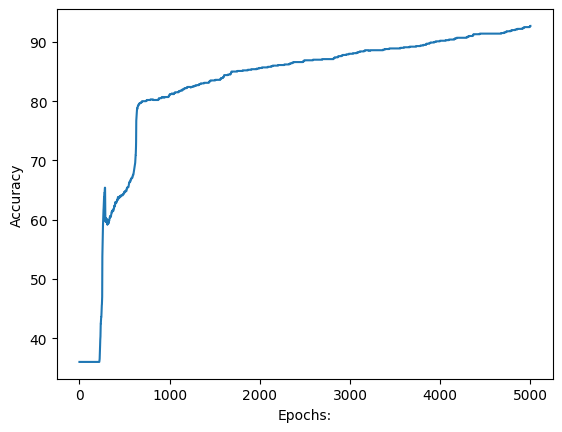

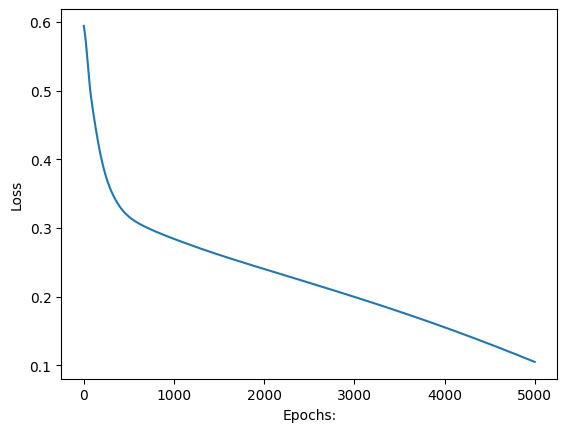

Targets - Predictions - Results
[0] => [0.08297218] => [0.]
[0] => [0.3354994] => [0.]
[0] => [-0.1758635] => [-0.]
[0] => [0.12955779] => [0.]
[2] => [1.31572737] => [1.]
[0] => [1.62091803] => [2.]
[1] => [1.31301645] => [1.]
[1] => [1.51254419] => [2.]
[2] => [1.29243664] => [1.]
[0] => [0.0353223] => [0.]
[2] => [1.76748119] => [2.]
[1] => [0.75712578] => [1.]
[0] => [0.31599759] => [0.]
[1] => [1.25211556] => [1.]
[1] => [0.93082051] => [1.]
[0] => [0.03665521] => [0.]
[0] => [0.1027915] => [0.]
[0] => [0.13673921] => [0.]
[2] => [1.71547893] => [2.]
[0] => [0.20534] => [0.]
[1] => [1.49351861] => [1.]
[0] => [0.65163886] => [1.]
[2] => [1.68394828] => [2.]
[0] => [-0.04295978] => [-0.]
[2] => [1.63961237] => [2.]
[0] => [0.1181097] => [0.]
[1] => [1.71779115] => [2.]
[2] => [1.48138169] => [1.]
[2] => [0.9964077] => [1.]
[2] => [2.03763098] => [2.]
[1] => [1.30987981] => [1.]
[2] => [1.52150385] => [2.]
[0] => [1.45263863] => [1.]
[0] => [-0.12076094] => [-0.]
[2] => [1.49838284]

In [9]:
seed_value: bool = True

net1 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
])

train(net1, inputs=dataset1_train.values, targets=labels_train.values, loss=MeanSquareError(), num_epochs=5000)

validate(net1, inputs=dataset1_validation.values, targets=labels_validation.values, loss=MeanSquareError())

Epoch =  0  Loss =  0.8839537916283462  Acc =  54.50000000000001
Epoch =  100  Loss =  0.34870247343929306  Acc =  83.39999999999999
Epoch =  200  Loss =  0.28837689522172105  Acc =  87.4
Epoch =  300  Loss =  0.2602762075354305  Acc =  89.60000000000001
Epoch =  400  Loss =  0.245336304252604  Acc =  90.3
Epoch =  500  Loss =  0.2341536276337341  Acc =  91.0
Epoch =  600  Loss =  0.22447765435718997  Acc =  91.4
Epoch =  700  Loss =  0.21544630124701292  Acc =  91.60000000000001
Epoch =  800  Loss =  0.20666058953448466  Acc =  91.9
Epoch =  900  Loss =  0.19789419447346449  Acc =  92.4
Epoch =  1000  Loss =  0.1889867764091424  Acc =  92.60000000000001
Epoch =  1100  Loss =  0.17982658718658537  Acc =  93.2
Epoch =  1200  Loss =  0.17035250993105422  Acc =  93.4
Epoch =  1300  Loss =  0.1605502459342831  Acc =  94.19999999999999
Epoch =  1400  Loss =  0.1504487968277441  Acc =  95.3
Epoch =  1500  Loss =  0.14012080184538833  Acc =  96.3
Epoch =  1600  Loss =  0.1296866434404567  Acc

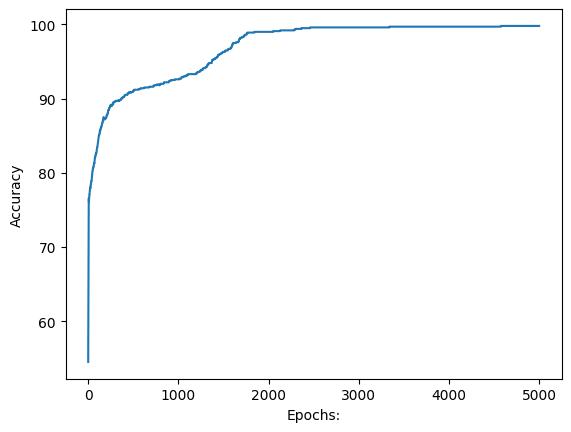

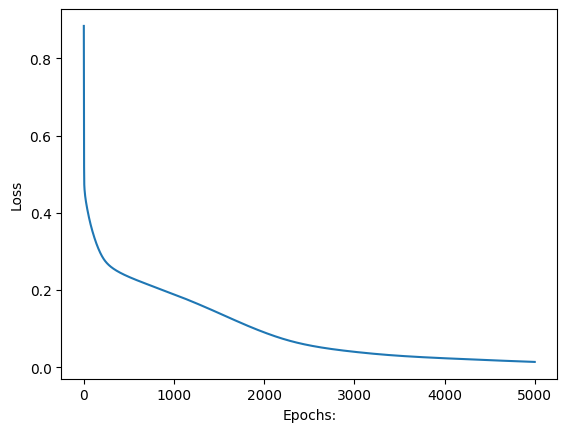

Targets - Predictions - Results
[0] => [0.03252021] => [0.]
[0] => [0.97681098] => [1.]
[0] => [0.03260007] => [0.]
[0] => [0.22027665] => [0.]
[1] => [0.99880601] => [1.]
[0] => [0.99588067] => [1.]
[1] => [0.99885686] => [1.]
[1] => [0.99882559] => [1.]
[1] => [0.99884654] => [1.]
[0] => [0.01767672] => [0.]
[1] => [0.9988177] => [1.]
[1] => [0.12856114] => [0.]
[0] => [0.05909994] => [0.]
[1] => [0.9957697] => [1.]
[1] => [0.20401979] => [0.]
[0] => [0.02771305] => [0.]
[0] => [0.01468242] => [0.]
[0] => [0.02352526] => [0.]
[1] => [0.99882158] => [1.]
[0] => [0.050382] => [0.]
[1] => [0.99881712] => [1.]
[0] => [0.05887016] => [0.]
[1] => [0.99883467] => [1.]
[0] => [0.01679036] => [0.]
[1] => [0.9981536] => [1.]
[0] => [0.03182603] => [0.]
[1] => [0.99882904] => [1.]
[1] => [0.99881191] => [1.]
[1] => [0.92334521] => [1.]
[1] => [0.99888249] => [1.]
[1] => [0.99885794] => [1.]
[1] => [0.96975769] => [1.]
[0] => [0.79711197] => [1.]
[0] => [0.00992745] => [0.]
[1] => [0.99885226] =

In [10]:
net2 = NeuralNet([
    Linear(input_size=12, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=6, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4, Seed=seed_value),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=1, Seed=seed_value),
    Activation(sigmoid, sigmoid_prime),
])

train(net2, inputs=dataset1_train.values, targets=bin_labels_train, loss=BinCrossEntropy(), num_epochs=5000)

validate(net2, inputs=dataset1_validation.values, targets=bin_labels_validation, loss=BinCrossEntropy())